# Static Plots

- [pandas.DataFrame.plot — pandas 1.4.1 documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)
- [Matplotlib — Visualization with Python](https://matplotlib.org/)
- [seaborn: statistical data visualization — seaborn 0.11.2 documentation](https://seaborn.pydata.org/)
- [Chart Visualization — pandas 1.4.2 documentation](https://pandas.pydata.org/docs/user_guide/visualization.html)



## 対象者

- pandas DataFrame / Series の plot 機能を使って、静的な描画を簡単に行いたい方
- そこそこのデータ量でサクッと描画を行いたい方
- df.plot() は何となく知っている方

## 目次
- df.plot() を使い倒す（倒したい）
- matplotlib を組み合わせて描画する
- 価格帯別出来高とMarket Depth を 描画する


## データ
- cryptochasis の約定データを使ってOHLCVデータを作成
- [crypto-chassis/cryptochassis-data-api-docs: A REST API providing snapshot, tick, and aggregated market data for crypto-currencies](https://github.com/crypto-chassis/cryptochassis-data-api-docs#trade)
- スクリプトは `data.py` に記載しています


In [1]:
# warning 非表示
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.__version__

'1.4.2'

In [2]:
df_btc_eur =pd.read_pickle("../data/binance_btc-eur.pkl")
df_btc_eur.head()


,time_seconds,price,size,is_buyer_maker,instrument
datetime,,,,,
2022-03-15 00:00:01.414000128+00:00,1.647302e+09,36300.77,0.00115,1,btc-eur
2022-03-15 00:00:01.472000+00:00,1.647302e+09,36303.01,0.00825,0,btc-eur
2022-03-15 00:00:03.670000128+00:00,1.647302e+09,36306.47,0.01195,0,btc-eur
2022-03-15 00:00:04.072000+00:00,1.647302e+09,36306.57,0.01912,0,btc-eur
2022-03-15 00:00:04.108999936+00:00,1.647302e+09,36306.57,0.00389,0,btc-eur


In [3]:
df_btc_eur.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 770101 entries, 2022-03-15 00:00:01.414000128+00:00 to 2022-03-22 23:59:47.063000064+00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   time_seconds    770101 non-null  float64
 1   price           770101 non-null  float64
 2   size            770101 non-null  float64
 3   is_buyer_maker  770101 non-null  int64  
 4   instrument      770101 non-null  object 
dtypes: float64(3), int64(1), object(1)
memory usage: 35.3+ MB


In [4]:
# 5分のOHLCVに変換
# 参照: Botterのためのpandas入門 https://botter4pandas.readthedocs.io/ja/latest/resample.html

rule="5min"
df_ohlc_btc_eur = df_btc_eur["price"].resample(rule, label="right").ohlc()
df_ohlc_btc_eur["volume"] = df_btc_eur["size"].resample(rule, label="right").sum()
df_ohlc_btc_eur.head()

,open,high,low,close,volume
datetime,,,,,
2022-03-14 00:05:00+00:00,34705.92,34736.71,34681.75,34730.34,6.62146
2022-03-14 00:10:00+00:00,34732.31,34732.31,34628.84,34637.02,9.43070
2022-03-14 00:15:00+00:00,34648.05,34658.28,34512.04,34573.60,10.00064
2022-03-14 00:20:00+00:00,34573.59,34800.00,34569.75,34722.50,14.08364
2022-03-14 00:25:00+00:00,34723.95,34751.51,34687.19,34737.34,5.59076


## df.plot() を使い倒す

`plot()` にはたくさんのオプションがあります。matplotlib や seaborn などを使わなくても事足りることがありますのでぜひ覚えてください。
- [pandas.DataFrame.plot — pandas 1.4.2 documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)


### plot メソッド

`plot()` はデフォルトで折れ線グラフを描画


<AxesSubplot:xlabel='datetime'>

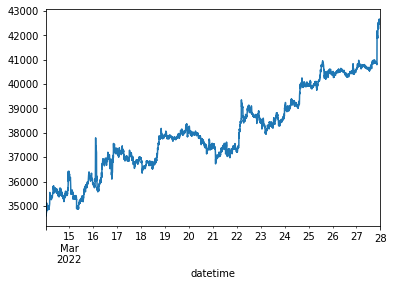

In [5]:
# close を折れ線でグラフで描画
df_ohlc_btc_eur["close"].plot()

### plot オプション

罫線や描画サイズなど、オプションで変更できます。

<AxesSubplot:title={'center':'Close'}, xlabel='datetime'>

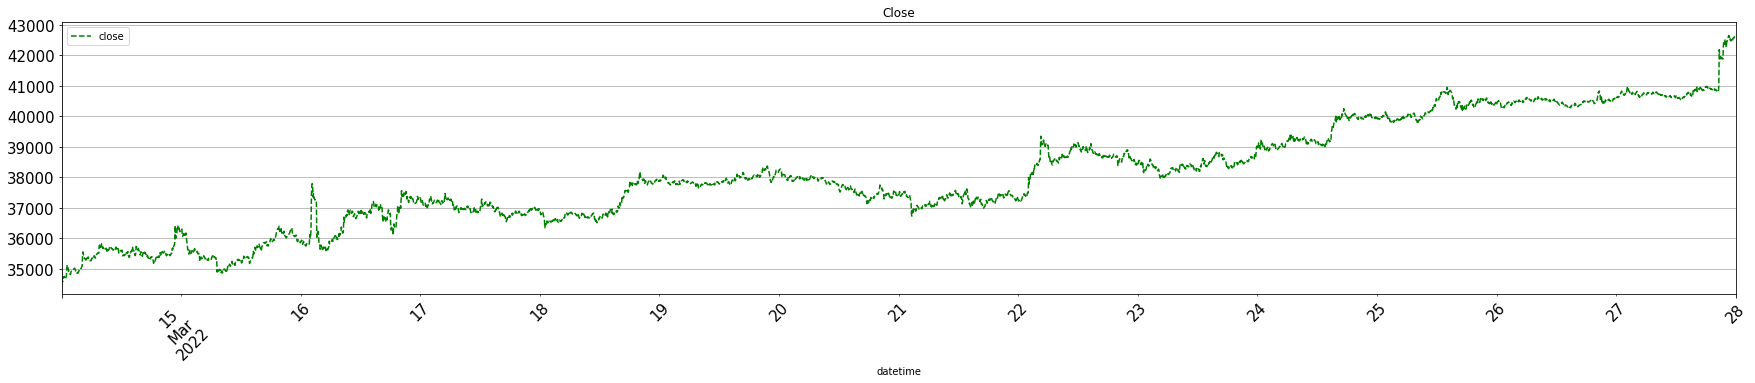

In [6]:
df_ohlc_btc_eur["close"].plot(
    grid=True, # 罫線
    figsize=(30,5),  # 描画サイズ。インチ（横、縦）
    title="Close",  # グラフタイトル
    legend=True,  # 凡例
    rot=45,  # xtick の ローテーション
    fontsize=15, # 文字サイズ
    style={"close": "g--"}, # 色と線の種類,
    )

### サブプロット

同じ DataFrame にあるデータであれば、 `subplots=True,` オプションでサブプロットできます

In [7]:
import ta
df_ohlc_btc_eur["RSI14"] = ta.momentum.rsi(df_ohlc_btc_eur["close"], window=14)

In [8]:
df_ohlc_btc_eur.tail()

,open,high,low,close,volume,RSI14
datetime,,,,,,
2022-03-27 23:40:00+00:00,42562.98,42597.70,42562.98,42597.05,2.07900,64.928033
2022-03-27 23:45:00+00:00,42588.73,42689.65,42562.14,42640.47,7.48831,66.828193
2022-03-27 23:50:00+00:00,42630.94,42659.99,42624.24,42658.11,1.58642,67.596294
2022-03-27 23:55:00+00:00,42659.26,42697.08,42640.03,42681.68,3.57939,68.641147
2022-03-28 00:00:00+00:00,42694.95,42699.77,42643.83,42665.67,2.87171,67.059402


array([[<AxesSubplot:xlabel='datetime'>],
       [<AxesSubplot:xlabel='datetime'>]], dtype=object)

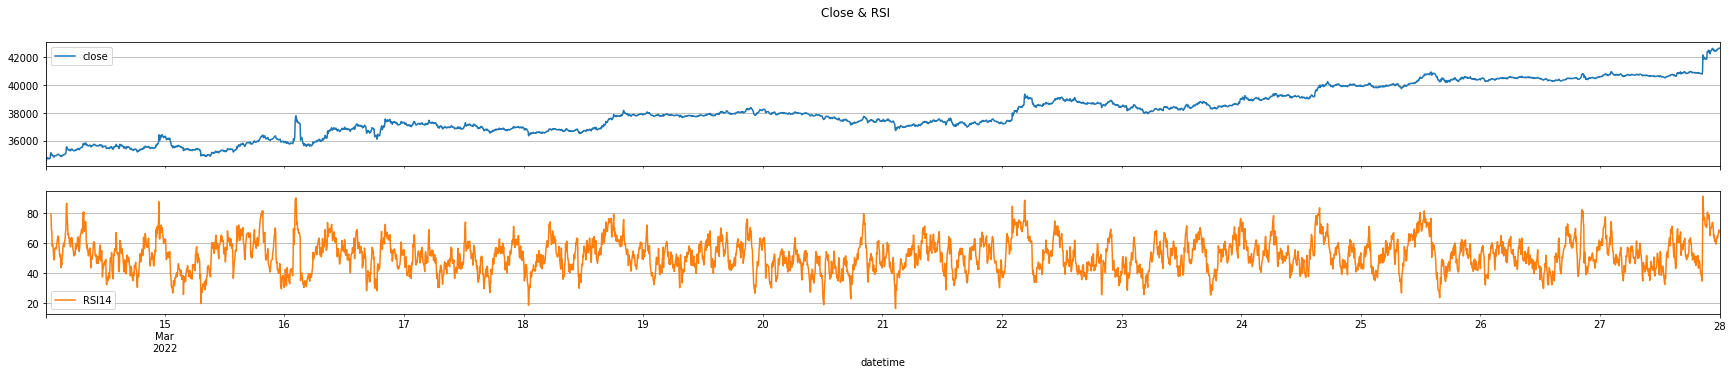

In [9]:
df_ohlc_btc_eur[["close", "RSI14"]].plot(
    grid=True, 
    figsize=(30,5), 
    title="Close & RSI", 
    legend=True, 
    subplots=True, 
    layout=(2,1), # レイアウト（行,列）
    )

### 第二軸

`secondary_y=` オプションで、右側にｙの第二軸を取ることができます

<AxesSubplot:xlabel='datetime'>

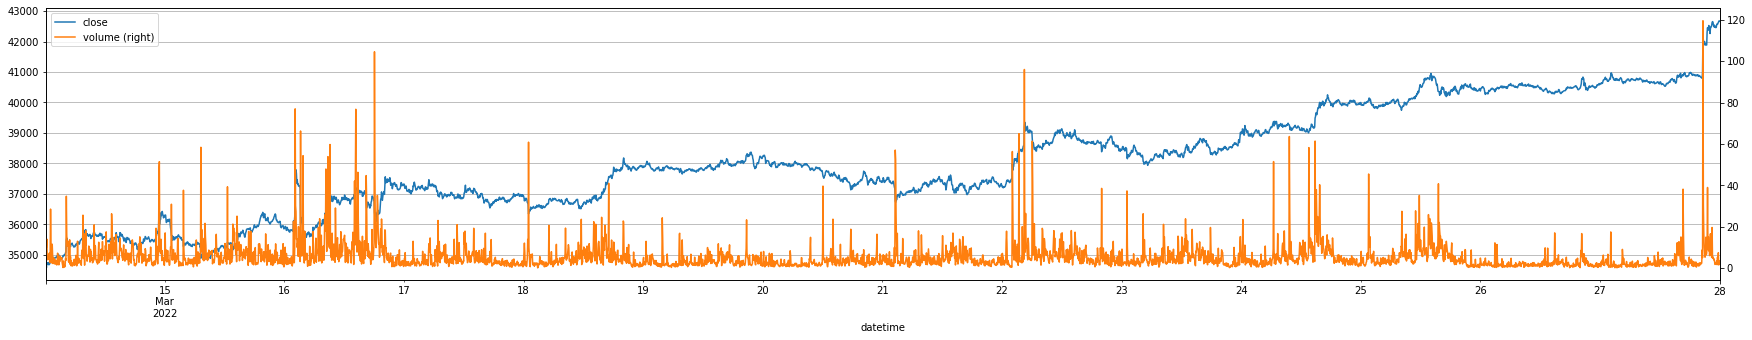

In [10]:
df_ohlc_btc_eur[["close", "volume"]].plot(
    grid=True,    
    figsize=(30,5),
    secondary_y="volume", 
    )

### bar について

- bar は描画に時間がかかります。
- 代わりに `area` を使うのが1つの方法かと思います。

<AxesSubplot:xlabel='datetime'>

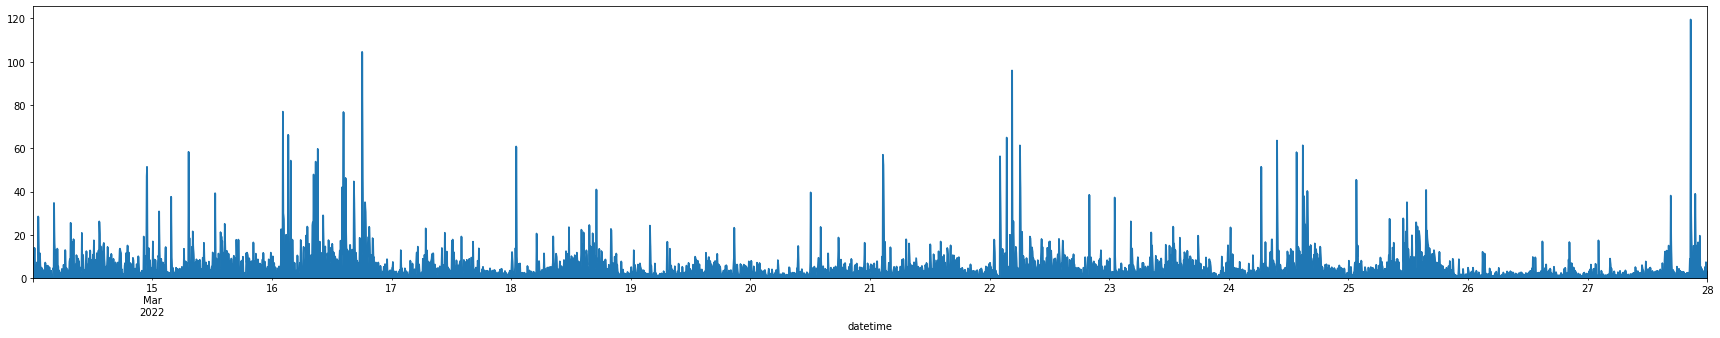

In [11]:
# df_ohlc_btc_eur["volume"].head(100).plot(kind="bar", use_index = False, figsize=(30,5) )
df_ohlc_btc_eur["volume"].plot(kind="area", figsize=(30,5))



### 日本語豆腐問題

<AxesSubplot:title={'center':'終値'}, xlabel='時間', ylabel='価格'>

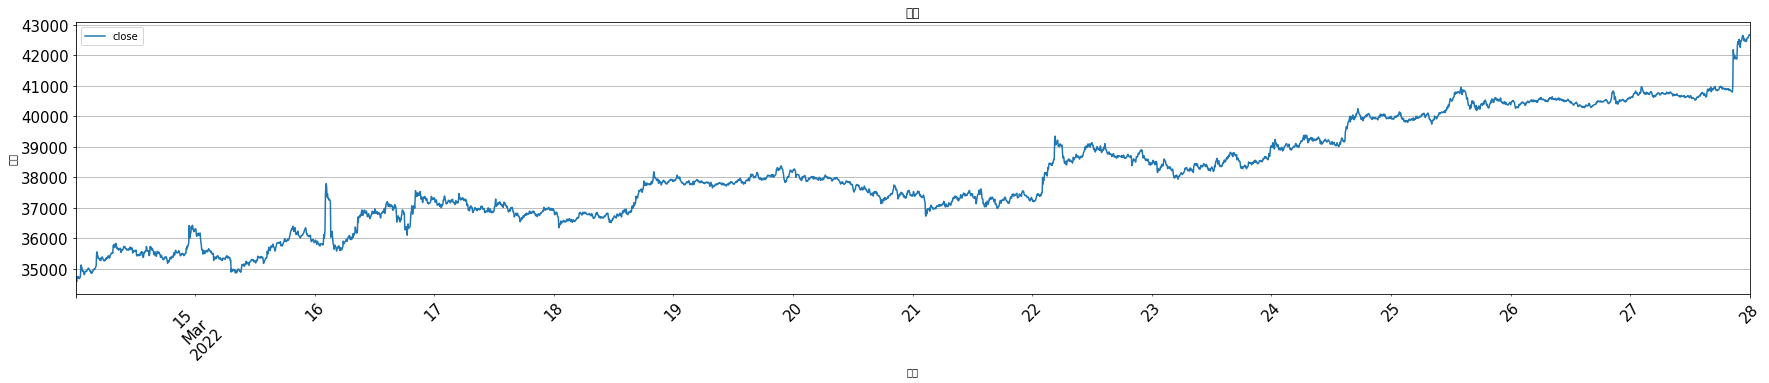

In [12]:
df_ohlc_btc_eur["close"].plot(grid=True, figsize=(30,5), title="終値", legend=True, rot=45, fontsize=15, xlabel="時間", ylabel="価格")

<AxesSubplot:title={'center':'終値'}, xlabel='時間', ylabel='価格'>

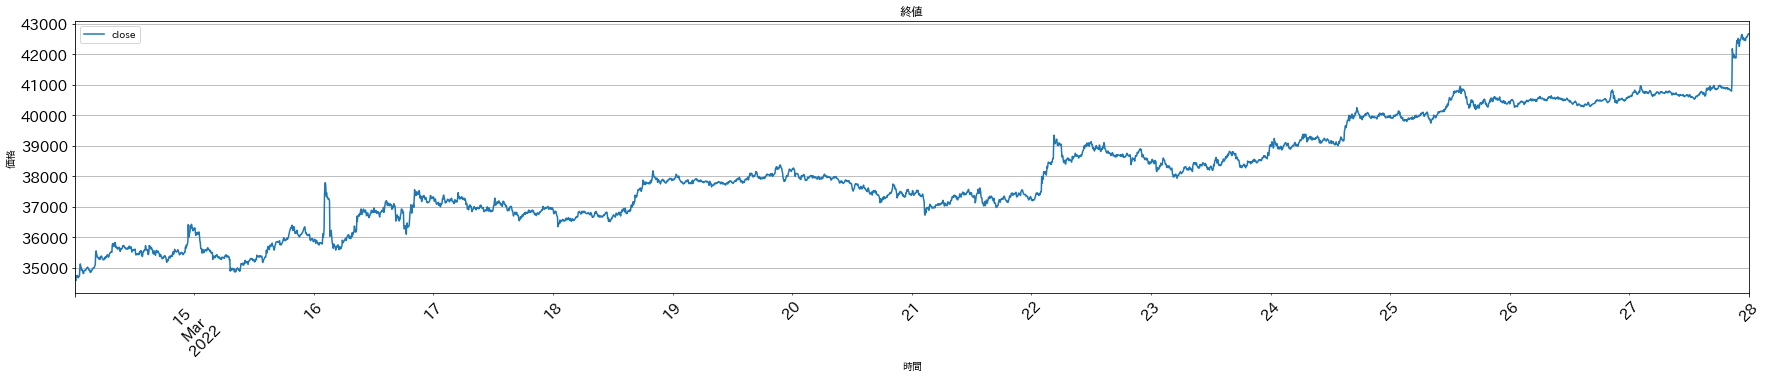

In [13]:
import japanize_matplotlib

df_ohlc_btc_eur["close"].plot(grid=True, figsize=(30,5), title="終値", legend=True, rot=45, fontsize=15, xlabel="時間", ylabel="価格")


## matplotlib と組み合わせて描画する
- `.plot()` だけでは表現できない時は `matplotloib` を使います
- 例：価格変化を曜日ごとにサブプロットで描画したい


### matplotlib でサブプロットする

1. `add_subplot`
1. `subplots` 

### add_subplot

```python
import matplotlib.pyplot as plt 
fig = plt.figure()
fig.add_subplot(行数,列数,インデックス)
```

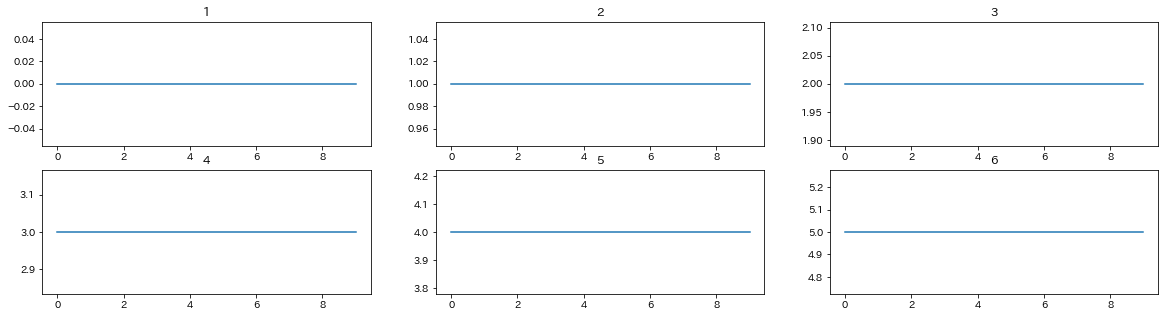

In [14]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(20,5))

for i in range(6):
    ax = fig.add_subplot(2,3,i+1) # インデックスは１始まり
    pd.Series([i]*10).plot(ax=ax, title=i+1)



### subplots

```python
import matplotlib.pyplot as plt
fig, axes = plt.subplots(行数, 列数)
```

<AxesSubplot:title={'center':'[1,2]'}>

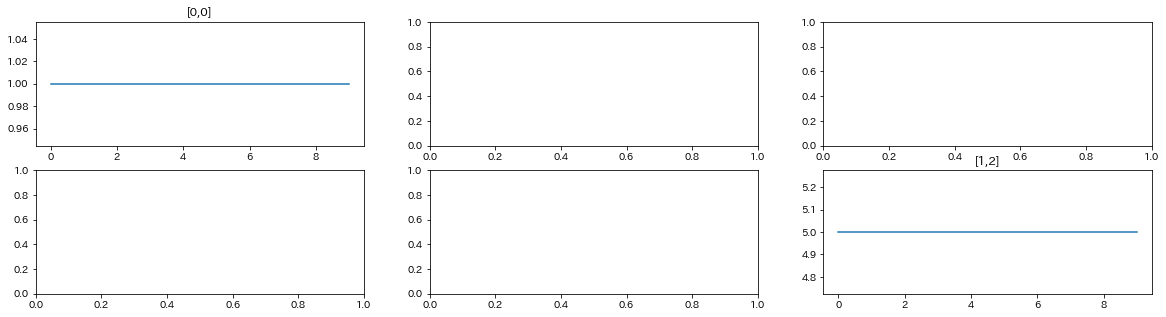

In [15]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(20, 5))

pd.Series([1]*10).plot(ax=axes[0,0], title="[0,0]")
pd.Series([5]*10).plot(ax=axes[1,2], title="[1,2]")


### 曜日ごとに分けてヒストグラムを描画
- `df.plot(subplots=True)` は複数データが全く同じIndexを持つ場合は使用出来ますが、groupby などで分割したデータには使用出来ません。
- その場合は `matolotlib` の `subplots` などを使う必要があります


In [16]:
df_ohlc_btc_eur["day_name"] = df_ohlc_btc_eur.index.day_name() # もしくは dayofweek (Monday=0, Sunday=6)
df_ohlc_btc_eur["price_change"] = df_ohlc_btc_eur["close"].pct_change()
df_ohlc_btc_eur.tail()

,open,high,low,close,volume,RSI14,day_name,price_change
datetime,,,,,,,,
2022-03-27 23:40:00+00:00,42562.98,42597.70,42562.98,42597.05,2.07900,64.928033,Sunday,0.000801
2022-03-27 23:45:00+00:00,42588.73,42689.65,42562.14,42640.47,7.48831,66.828193,Sunday,0.001019
2022-03-27 23:50:00+00:00,42630.94,42659.99,42624.24,42658.11,1.58642,67.596294,Sunday,0.000414
2022-03-27 23:55:00+00:00,42659.26,42697.08,42640.03,42681.68,3.57939,68.641147,Sunday,0.000553
2022-03-28 00:00:00+00:00,42694.95,42699.77,42643.83,42665.67,2.87171,67.059402,Monday,-0.000375


<AxesSubplot:ylabel='Frequency'>

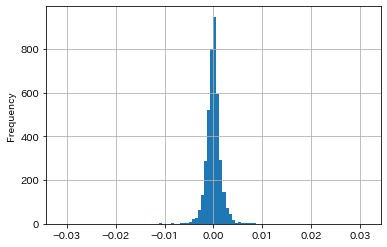

In [17]:
df_ohlc_btc_eur["price_change"].plot(kind="hist", bins=100, grid=True)

day_name
Friday       AxesSubplot(0.125,0.125;0.775x0.755)
Monday       AxesSubplot(0.125,0.125;0.775x0.755)
Saturday     AxesSubplot(0.125,0.125;0.775x0.755)
Sunday       AxesSubplot(0.125,0.125;0.775x0.755)
Thursday     AxesSubplot(0.125,0.125;0.775x0.755)
Tuesday      AxesSubplot(0.125,0.125;0.775x0.755)
Wednesday    AxesSubplot(0.125,0.125;0.775x0.755)
Name: price_change, dtype: object

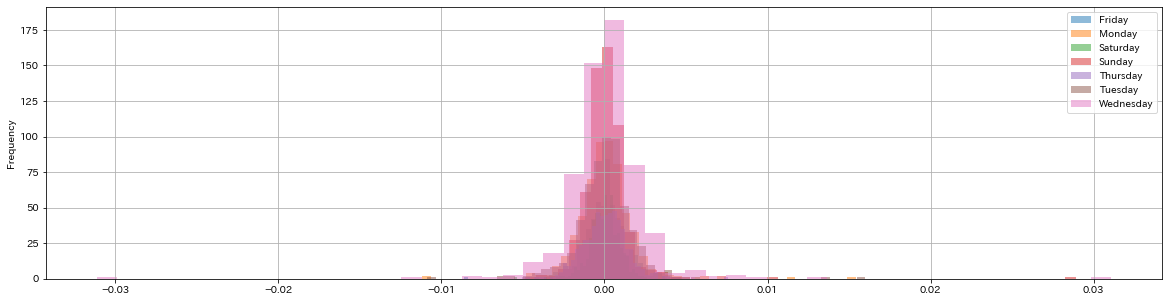

In [18]:
df_ohlc_btc_eur.groupby("day_name")["price_change"].plot(kind="hist", bins=50, grid=True, legend=True, figsize=(20,5), alpha=0.5, )

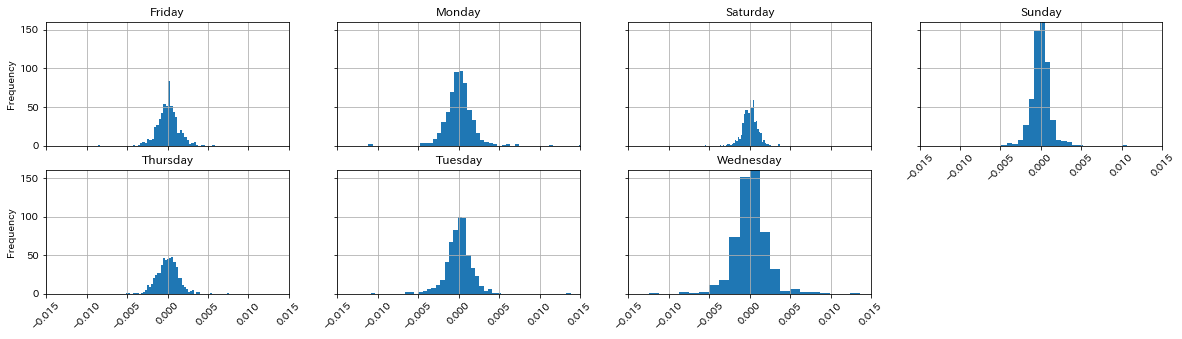

In [19]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(20,5))

i = 1
for name, s in list(df_ohlc_btc_eur.groupby("day_name")["price_change"]):
    ax = fig.add_subplot(2,4,i)
    s.plot(kind="hist", ax=ax, title=name, xlim=(-0.015, 0.015), ylim=(0, 160), sharex=True, sharey=True,  grid=True, bins=50, rot=45) 
    i += 1
    

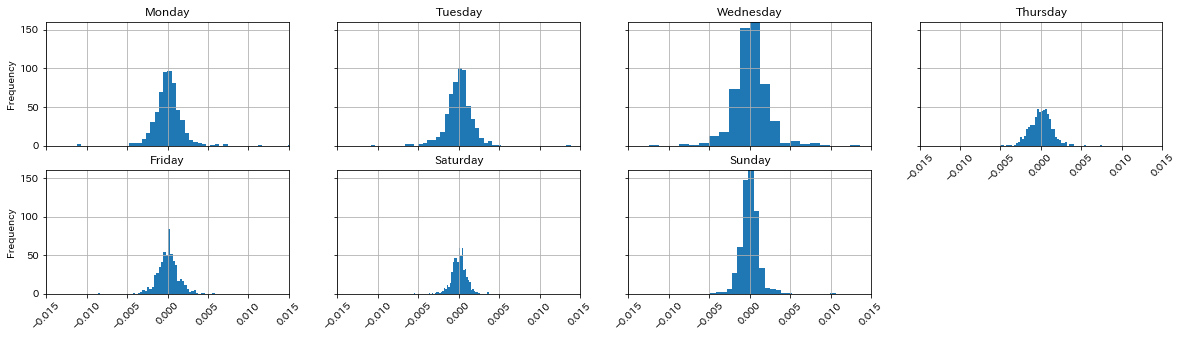

In [20]:
daynames=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(20,5))

i = 1
grp = df_ohlc_btc_eur.groupby("day_name")["price_change"]
for name in daynames:
    s = grp.get_group(name)
    ax = fig.add_subplot(2,4,i)
    s.plot(kind="hist", ax=ax, title=name, xlim=(-0.015, 0.015), ylim=(0, 160), sharex=True, sharey=True,  grid=True, bins=50, rot=45) 
    i += 1    

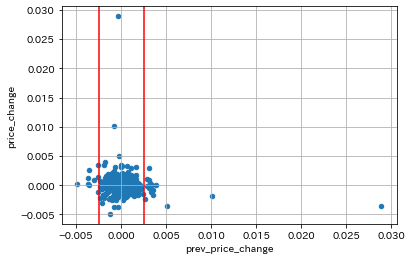

In [21]:
df_ohlc_btc_eur["prev_price_change"] = df_ohlc_btc_eur["price_change"].shift(2)
ax = df_ohlc_btc_eur[df_ohlc_btc_eur["day_name"] == "Sunday"].plot(kind="scatter", x = "prev_price_change", y="price_change", grid=True)
ax.axvline(-0.0025, c="red")
ax.axvline(0.0025, c="red")


### 価格帯別出来高
- 頂いたアンケートで、価格帯別出来高と market depth の描画についてのご質問が多かったので、この2つを .plot と matplotlib で描画する方法を紹介



In [22]:
# 15分OHLCVを作成
df_15min = df_btc_eur["price"].resample("15min", label="right").ohlc()
df_15min["volume"] = df_btc_eur["size"].resample("15min", label="right").sum()

# pandas.cut https://pandas.pydata.org/docs/reference/api/pandas.cut.html
df_15min["pricecut"] = pd.cut(df_15min["close"], 30, ).apply(lambda x: x.left)
s_vol_by_price = df_15min.groupby("pricecut")["volume"].sum()

In [23]:
pd.cut(df_15min["close"], 30, ).apply(lambda x: x.left).tail()

datetime
2022-03-27 23:00:00+00:00    42395.934
2022-03-27 23:15:00+00:00    42395.934
2022-03-27 23:30:00+00:00    42395.934
2022-03-27 23:45:00+00:00    42395.934
2022-03-28 00:00:00+00:00    42395.934
Freq: 15T, Name: close, dtype: category
Categories (30, float64): [34565.508 < 34843.336 < 35113.071 < 35382.807 ... 41586.727 < 41856.463 < 42126.199 < 42395.934]

In [24]:
df_15min.tail()

,open,high,low,close,volume,pricecut
datetime,,,,,,
2022-03-27 23:00:00+00:00,42570.70,42585.16,42450.00,42471.61,11.39878,42395.934
2022-03-27 23:15:00+00:00,42475.62,42557.37,42420.90,42454.44,6.61628,42395.934
2022-03-27 23:30:00+00:00,42462.01,42589.44,42452.42,42577.18,7.51905,42395.934
2022-03-27 23:45:00+00:00,42593.08,42689.65,42524.29,42640.47,14.85681,42395.934
2022-03-28 00:00:00+00:00,42630.94,42699.77,42624.24,42665.67,8.03752,42395.934


<AxesSubplot:ylabel='pricecut'>

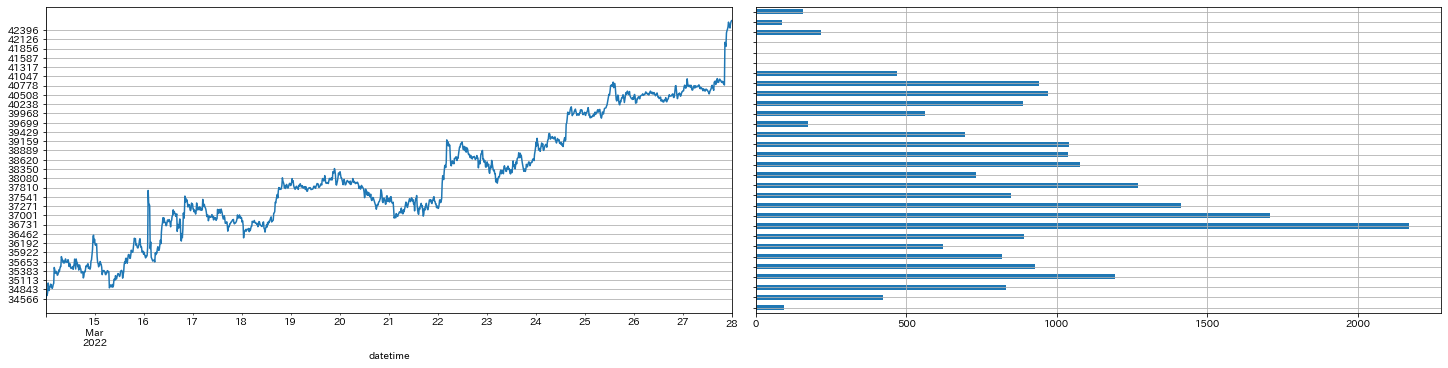

In [25]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(20, 5), constrained_layout = True) # constrained_layout: サブプロット同士をいい感じで描画
df_15min["close"].plot(ax=axes[0], yticks=s_vol_by_price.index, grid=True)
s_vol_by_price.plot(kind="barh",ax=axes[1],sharey=True, grid=True)


### Market Depth

![](https://upload.wikimedia.org/wikipedia/commons/1/1f/Market_Depth.jpg)

In [26]:
import asyncio
import nest_asyncio
import pandas as pd
import plotly.graph_objects as go
import pybotters
from IPython.display import HTML

nest_asyncio.apply()


In [27]:
async def get_trades(market_name):
    async with pybotters.Client(
        apis={"ftx": ["", ""]}, base_url="https://ftx.com/api"
    ) as client:
        res = await client.get(
            f"/markets/{market_name}/orderbook",
            params={"depth": 100,},
        )
        return await res.json()

# 取得したデータを確認
data = asyncio.run(get_trades("BTC-PERP"))


In [28]:
df_bid = pd.DataFrame(data["result"]["bids"], columns=["price","size"]).sort_values("price")
df_ask = pd.DataFrame(data["result"]["asks"], columns=["price","size"]).sort_values("price")


[Text(0, 0, '38997.0'),
 Text(1, 0, '38998.0'),
 Text(2, 0, '38999.0'),
 Text(3, 0, '39000.0'),
 Text(4, 0, '39001.0'),
 Text(5, 0, '39002.0'),
 Text(6, 0, '39003.0'),
 Text(7, 0, '39004.0'),
 Text(8, 0, '39005.0'),
 Text(9, 0, '39006.0'),
 Text(10, 0, '39007.0'),
 Text(11, 0, '39008.0'),
 Text(12, 0, '39009.0'),
 Text(13, 0, '39010.0'),
 Text(14, 0, '39011.0'),
 Text(15, 0, '39012.0'),
 Text(16, 0, '39013.0'),
 Text(17, 0, '39014.0'),
 Text(18, 0, '39015.0'),
 Text(19, 0, '39016.0'),
 Text(20, 0, '39017.0'),
 Text(21, 0, '39018.0'),
 Text(22, 0, '39019.0'),
 Text(23, 0, '39020.0'),
 Text(24, 0, '39021.0'),
 Text(25, 0, '39022.0'),
 Text(26, 0, '39023.0'),
 Text(27, 0, '39024.0'),
 Text(28, 0, '39025.0'),
 Text(29, 0, '39026.0'),
 Text(30, 0, '39027.0'),
 Text(31, 0, '39028.0'),
 Text(32, 0, '39029.0'),
 Text(33, 0, '39030.0'),
 Text(34, 0, '39031.0'),
 Text(35, 0, '39032.0'),
 Text(36, 0, '39033.0'),
 Text(37, 0, '39034.0'),
 Text(38, 0, '39035.0'),
 Text(39, 0, '39036.0'),
 Text(40, 

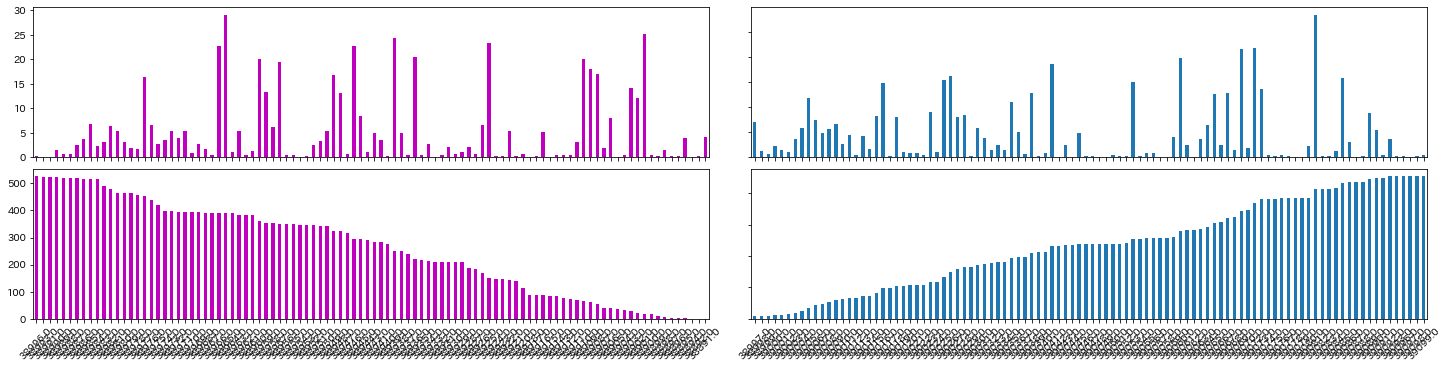

In [29]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(20, 5), constrained_layout = True)

df_bid["size"][::-1].plot(kind="bar", ax=axes[0,0], color="m", sharex=axes[1,0]) 
df_bid["size"][::-1].cumsum()[::-1].plot(kind="bar", ax=axes[1,0], color="m", rot=45)
axes[1,0].set_xticklabels(df_bid["price"][::-1])


df_ask["size"].plot(kind="bar", ax=axes[0,1], sharex=axes[0,1], sharey=[0,0])
df_ask["size"].cumsum().plot(kind="bar", ax=axes[1,1], rot=45)
axes[1,1].set_xticklabels(df_ask["price"])


## テーマ変更

matplotlibのstyleを変える - Qiita
https://qiita.com/eriksoon/items/b93030ba4dc686ecfbba

[Style sheets reference — Matplotlib 3.5.1 documentation](https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html)




In [30]:
plt.style.use("bmh")